# This notebook contains scripts that generate figures of Clinical Variants experiment

In [ ]:
import pandas as pd
# This result file has been generated by multiprocess_clinvar_analysis.py script.
res_data = pd.read_csv("result_files/clinvar_analysis.csv")

# Process RANDOM baseline
random_mask = res_data["dataset"].str.startswith("Rand")
group_keys = ["vocab_size", "matrix", "config", "is_pre"]

mean_sibling = res_data[random_mask].groupby(group_keys)["same_sibling_rate"].mean()
mean_idx = res_data[random_mask].groupby(group_keys)["same_idx"].mean()
collapsed = pd.concat([mean_sibling, mean_idx], axis=1).reset_index()
collapsed["dataset"] = "Random"
res_data = pd.concat([res_data[~random_mask], collapsed], ignore_index=True).reset_index().drop(columns="Unnamed: 0")
res_data.head()

,index,dataset,matrix,same_idx,same_sibling_rate,vocab_size,config,is_pre
0,0,Benign,blosum62,0.600807,0.056010,800,0.7_3_12_0,False
1,1,Benign,blosum62,0.582029,0.000000,6400,bpe,False
2,2,Benign,blosum62,0.564748,0.229643,51200,0.7_3_12_0.1,False
3,3,Benign,blosum62,0.608162,0.031038,1600,0.8_3_12_0.2,False
4,4,Benign,blosum62,0.549907,0.130141,51200,0.8_3_12_0.2,False


In [2]:
config_mask = res_data["config"] != "bpe"

same_idx_data_mean = res_data[config_mask].groupby(["dataset", "vocab_size"])["same_idx"].mean()
same_idx_data_std = res_data[config_mask].groupby(["dataset", "vocab_size"])["same_idx"].std()
same_sibling_data_mean = res_data[config_mask].groupby(["dataset", "vocab_size"])["same_sibling_rate"].mean()
same_sibling_data_std = res_data[config_mask].groupby(["dataset", "vocab_size"])["same_sibling_rate"].std()

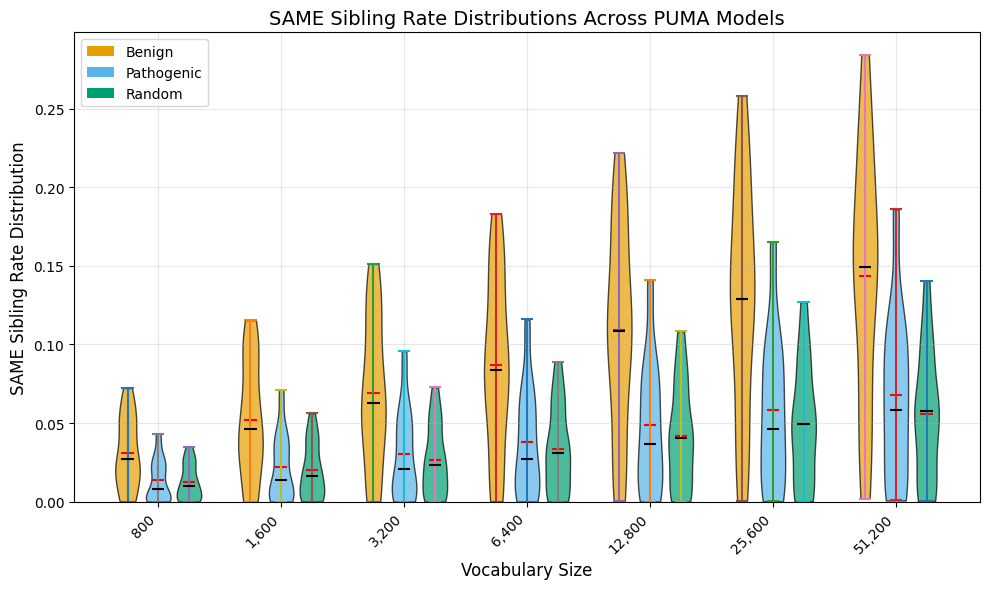

In [3]:
import matplotlib.pyplot as plt

# --- plot ---
fig, ax1 = plt.subplots(figsize=(10, 6))


colors = {
    "Benign": "#E69F00", 
    "Pathogenic": "#56B4E9", 
    "Random": "#009E73",
}

datasets = ["Benign", "Pathogenic", "Random"]
offset = 0.25  # horizontal offset for separation
x_vals = sorted(res_data["vocab_size"].unique())

for i, ((dataset_str, ), group) in enumerate(res_data[config_mask].groupby(["dataset"])):
    for j, ((v_size, ), final_group) in enumerate(group.groupby(["vocab_size"])):
        vals = final_group["same_sibling_rate"].values

        # plot violin, shifted for visibility
        parts = ax1.violinplot(
            vals,
            positions=[j + (i - 1) * offset],  # shift left/center/right
            widths=0.2,
            showmeans=True,
            showmedians=True,
        )
        # colorize
        for pc in parts['bodies']:
            pc.set_facecolor(colors[dataset_str])
            pc.set_edgecolor("black")
            pc.set_alpha(0.7)
        if 'cmedians' in parts:
            parts['cmedians'].set_color("black")
        if 'cmeans' in parts:
            parts['cmeans'].set_color("red")

# --- labels, legend, cosmetics ---
ax1.set_xticks(range(len(x_vals)))
ax1.set_xticklabels([f"{v:,}" for v in x_vals], rotation=45, ha="right")
ax1.set_xlabel("Vocabulary Size", fontsize=12)
ax1.set_ylabel("SAME Sibling Rate Distribution", fontsize=12)
ax1.set_ylim(bottom=0)
ax1.set_title("SAME Sibling Rate Distributions Across PUMA Models", fontsize=14)
ax1.grid(True, alpha=0.3)

# custom legend
from matplotlib.patches import Patch
legend_handles = [Patch(facecolor=colors[d], label=d) for d in datasets]
ax1.legend(handles=legend_handles)

plt.tight_layout()
# plt.savefig("samesiblingrate.eps")
plt.show()
